In [22]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt


In [23]:
# Loading dataset

data = pd.read_csv('digester_data.csv', index_col=0, parse_dates=True)
data.head()

,Wash Filtrate to Digester - Total Flow,Wash Filtrate Vertical Nozzle,White Liquor Flow to ITC,H-factor,H-factor Co-Current,H-factor Target,H-factor Counter-Current,Volumetric Chip Flow,Chip Mass Flow from Piles,Spruce Saw Mill Chips Share,...,Hot Spent Digester Liquor Specific Flow to Impregnation Vessel,Digester Production,Digester Long Level,Digester Chip Level Control,Digester Dilution Factor,Digester Short Level,Blow Kappa,Blow Temperature,Blow Production,Weak Black Liquor to Evaporation Plant Residual Alkali
Time,,,,,,,,,,,,,,,,,,,,,
2018-11-17 05:30:00,110.2245,99.17144,0.666082,654.5113,343.3514,640.0,311.1599,562.5585,28.57158,0.0,...,2.700000,900.7260,88.44555,18.03286,2.087241,48.00631,27.06810,81.31033,944.3789,9.08
2018-11-17 05:40:00,110.1122,98.94392,0.664136,661.8202,346.3676,640.0,315.4526,633.1141,32.40237,0.0,...,2.700000,901.0746,88.48584,16.11140,2.120218,48.22581,26.91316,81.29632,935.1744,9.08
2018-11-17 05:50:00,110.5644,99.35569,0.663386,641.0970,347.7459,640.0,293.3511,639.0107,32.13532,0.0,...,2.700000,901.1793,88.58454,19.01828,2.094056,48.28634,26.75613,81.33907,943.5457,9.08
2018-11-17 06:00:00,111.6846,100.51020,0.667563,636.6735,340.1161,640.0,296.5574,566.5072,28.39081,0.0,...,2.699660,901.0532,88.60841,19.94156,2.074880,48.21948,26.29543,81.32839,942.8271,9.08
2018-11-17 06:10:00,113.5258,101.86900,0.683108,648.1323,344.1459,640.0,303.9865,476.2530,24.19455,0.0,...,2.675004,930.5841,88.82150,16.25405,2.121525,48.34011,25.98184,81.47342,959.3496,9.08


In [24]:
data_training = data[:'16.12.2018 05:30:00']
data_testing = data['16.12.2018 05:40:00':]

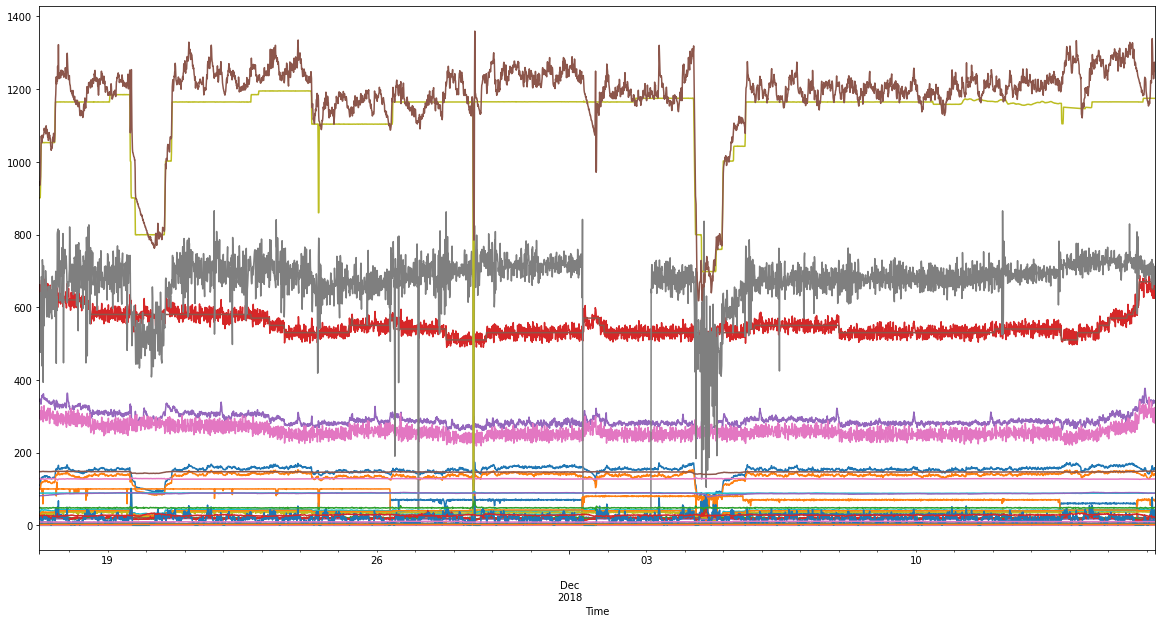

In [25]:
fig, ax = plt.subplots()
data_training.plot(legend=False, ax=ax, figsize=(20,10))
plt.show()


In [26]:
training_mean = data_training.mean()
training_std = data_training.std()
df_training_value = (data_training - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4177


In [36]:
TIME_STEPS = 100

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    print(range(len(values) - time_steps + 1))
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

4177
range(0, 4078)
Training input shape:  (4078, 100, 37)


In [28]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 50, 32)            8320      
                                                                 
 dropout_2 (Dropout)         (None, 50, 32)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 25, 16)            3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 50, 16)           1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 50, 16)            0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 100, 32)          3616      
 ranspose)                                            

In [10]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/50
42/42 [==============================] - 1s 19ms/step - loss: 0.9370 - val_loss: 0.7233
Epoch 2/50
42/42 [==============================] - 1s 16ms/step - loss: 0.9057 - val_loss: 0.7141
Epoch 3/50
42/42 [==============================] - 1s 15ms/step - loss: 0.9004 - val_loss: 0.7120
Epoch 4/50
42/42 [==============================] - 1s 17ms/step - loss: 0.8977 - val_loss: 0.7107
Epoch 5/50
42/42 [==============================] - 1s 16ms/step - loss: 0.8961 - val_loss: 0.7099
Epoch 6/50
42/42 [==============================] - 1s 15ms/step - loss: 0.8951 - val_loss: 0.7103
Epoch 7/50
42/42 [==============================] - 1s 15ms/step - loss: 0.8945 - val_loss: 0.7090
Epoch 8/50
42/42 [==============================] - 1s 15ms/step - loss: 0.8939 - val_loss: 0.7086
Epoch 9/50
42/42 [==============================] - 1s 15ms/step - loss: 0.8934 - val_loss: 0.7086
Epoch 10/50
42/42 [==============================] - 1s 15ms/step - loss: 0.8931 - val_loss: 0.7084
Epoch 11/

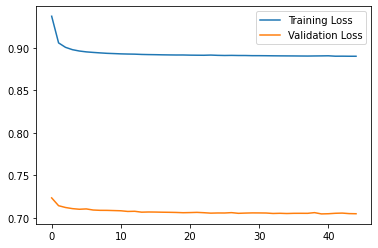

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


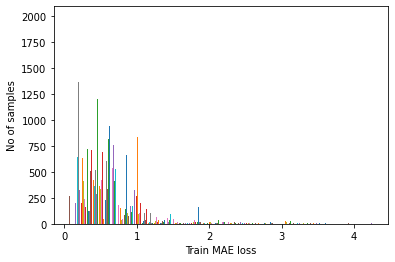

Reconstruction error threshold:  4.273182477605939


In [30]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


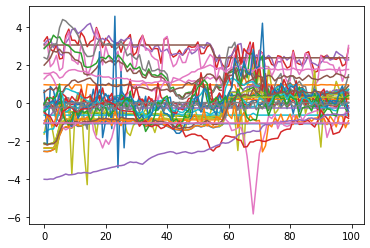

In [31]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()